In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pywt
from scipy.signal import wiener
import skimage as skimg 

from sklearn.preprocessing import (MinMaxScaler, StandardScaler)
# from sklearn.model_selection import (train_test_split,)
from sklearn.model_selection import (train_test_split, StratifiedKFold,)
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import (SVC)

from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.pipeline import (make_pipeline, make_union,)
from sklearn.metrics import (classification_report, accuracy_score)

import os
from tqdm import tqdm

In [3]:
class CLASS():
    FAKE = 0
    REAL = 1

### Load image for Cable, ICL

In [87]:
PATH_PREFIX = '/home/thienn17/Documents/ICL/'  # path to images
os.path.exists(PATH_PREFIX)

True

In [93]:
class LoadImage():
    def __init__(self, path_prefix, colorcvt=None):
        assert os.path.exists(path_prefix), "LoadImage, Path does not exist"
        self.path_prefix = path_prefix
        self.colorcvt = colorcvt

        self.cls_folders = [f for f in os.listdir(path_prefix) if f != 'dummy']
        self.cls_id = 0
        self.path_walk = os.walk(os.path.join(path_prefix, self.cls_folders[0]))
        
        self.images = []
        self.labels = []
    
    def reset(self):
        self.images = []
    
    def next_batch(self):
        try:
            while(True):
                abspath, _, files = next(self.path_walk)
                if len(files) > 0: break
            self.reset()
            print(abspath)
            for file in tqdm(files):
                img = cv2.imread(os.path.join(abspath, file))
                
                # up_left = (np.array(img.shape[:2], dtype=np.int16) // 2) - 500
                # # print(up_left)
                # img = img[up_left[0]:up_left[0]+1000, up_left[0]:up_left[0]+1000]
                # # print(img.shape)
                # # return
                
                if img is not None:
                    if self.colorcvt is not None:
                        img = cv2.cvtColor(img, self.colorcvt)
                    self.images.append(img)
                    self.labels.append(CLASS.REAL if self.cls_folders[self.cls_id][0] == 'S' else CLASS.FAKE)
            return self.images, self.labels
        except StopIteration:
            if self.cls_id < len(self.cls_folders)-1:
                self.cls_id += 1
                self.path_walk = os.walk(os.path.join(self.path_prefix, self.cls_folders[self.cls_id]))
                return self.next_batch()

        return None

    def next_batch_new(self):
        pass

### Feature modules

In [3]:
class WaveletTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, wtname = 'haar', level = 3):
        '''
        waveletname = ['haar', 'db3', 'db5', 'sym2', 'bior5.5', etc.]
        level: total number of decomposite level
        '''
        self.wtname = wtname
        self.level = level
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        features = []
        for img in tqdm(X):
            img_features = []
            for img_channel in np.moveaxis(img, -1, 0):
                wt = pywt.wavedec2(data=img_channel, wavelet=self.wtname, level=self.level)
                appr = wt[0]
                details = wt[1:]
                wt = [appr]
                for levels in details:
                    for detail in levels:
                        wt.append(detail)
                for _wt in wt:
                    img_features.append(np.mean(_wt))
                    img_features.append(np.var(_wt))
                    # img_features.append(np.mean((_wt - np.mean(_wt))**3))
            features.append(img_features)
        return features

In [4]:
class LBPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_points = 8, radius = 1, gray=False, noise=False):
        self.num_points = num_points
        self.radius = radius
        self.gray = gray
        self.noise = noise

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        features = []
        for img in tqdm(X):
            if self.gray:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                if self.noise:
                    img = img - wiener(img, 5)
                features.append(self.get_lbp_features((img,)))
            else:
                # print(img.shape)
                features.append(self.get_lbp_features(np.moveaxis(img, -1, 0)))
        return features

    def local_binary_pattern(self, img, normalized=True):
        lbp = skimg.feature.local_binary_pattern(
            img, self.num_points, self.radius, method="nri_uniform").ravel()
        # lbp = skimg.feature.local_binary_pattern(
        #     img, self.num_points, self.radius, method="default").ravel()
        (hist, bins) = np.histogram(lbp.ravel(), bins=59)
        # (hist, bins) = np.histogram(lbp.ravel(), bins=256)
        
        if normalized is False:
            return hist
        hist = hist / len(lbp)
        return hist

    def get_lbp_features(self, img_channels):
        lbp_features = np.zeros(59)
        # lbp_features = np.zeros(256)
        for img in img_channels:
            lbp_features += self.local_binary_pattern(img)
        return lbp_features / len(img_channels)

In [5]:
class Stat(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        features = []
        for img in tqdm(X):
            img_features = []
            for img_channel in np.moveaxis(img, -1, 0):
                img_features.append(np.mean(img_channel))
                img_features.append(np.var(img_channel))
            features.append(img_features)
        return features

### Extract

In [96]:
# # Wavelet
# LEVEL = 3
# extractor = WaveletTransformer(wtname='db5',level=LEVEL)
# A = np.empty((1, 3*2*(3*LEVEL+1)))  # channels * #feature * (#high_img * levels + #low-img)
# # A = np.empty((1,3*2*3*LEVEL))

# LBP
extractor = LBPTransformer(gray=True)
A = np.empty((1, 59))
# A = np.empty((1, 256))

In [97]:
b = None
loader = LoadImage(PATH_PREFIX, colorcvt=None)
batch = 1
while(True):
    print("Batch {}".format(batch))
    batch += 1

    res = loader.next_batch()
    if res is None:
        break
    images, b = res
    A = np.concatenate((A, extractor.transform(images)), axis=0)

Batch 1
/home/thienn17/Documents/ICL/SingleCaptureImages/EOS600D


100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


Batch 2
/home/thienn17/Documents/ICL/SingleCaptureImages/V550S


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Batch 3
/home/thienn17/Documents/ICL/SingleCaptureImages/D40


100%|██████████| 100/100 [01:16<00:00,  1.32it/s]


Batch 4
/home/thienn17/Documents/ICL/SingleCaptureImages/D40/not used


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Batch 5
/home/thienn17/Documents/ICL/SingleCaptureImages/V610


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Batch 6
/home/thienn17/Documents/ICL/SingleCaptureImages/V550B


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Batch 7
/home/thienn17/Documents/ICL/SingleCaptureImages/RX100


100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


Batch 8
/home/thienn17/Documents/ICL/SingleCaptureImages/TZ7


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


Batch 9
/home/thienn17/Documents/ICL/SingleCaptureImages/EPM2


100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


Batch 10
/home/thienn17/Documents/ICL/SingleCaptureImages/D70S


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Batch 11
/home/thienn17/Documents/ICL/RecapturedImages/TZ10


100%|██████████| 180/180 [01:20<00:00,  2.24it/s]


Batch 12
/home/thienn17/Documents/ICL/RecapturedImages/60D


100%|██████████| 180/180 [00:59<00:00,  3.04it/s]


Batch 13
/home/thienn17/Documents/ICL/RecapturedImages/D70s


100%|██████████| 180/180 [01:05<00:00,  2.76it/s]


Batch 14
/home/thienn17/Documents/ICL/RecapturedImages/D3200


100%|██████████| 180/180 [01:05<00:00,  2.77it/s]


Batch 15
/home/thienn17/Documents/ICL/RecapturedImages/600D


100%|██████████| 180/180 [01:05<00:00,  2.73it/s]


Batch 16
/home/thienn17/Documents/ICL/RecapturedImages/RX100


100%|██████████| 180/180 [00:57<00:00,  3.12it/s]


Batch 17
/home/thienn17/Documents/ICL/RecapturedImages/TZ7


100%|██████████| 180/180 [01:05<00:00,  2.73it/s]


Batch 18
/home/thienn17/Documents/ICL/RecapturedImages/EPM2


100%|██████████| 180/180 [01:12<00:00,  2.50it/s]

Batch 19


In [98]:
A = A[1:]
b = np.array(b)
A.shape

(2345, 256)

### Dump

In [99]:
PATH_DUMP = "../object dump/rose"
os.path.exists(PATH_DUMP)

True

In [53]:
FILE = "wt_YCC_3lv_db5"
np.save(os.path.join(PATH_DUMP, FILE+".npy"), A)
np.save(os.path.join(PATH_DUMP, FILE+"_label.npy"), b)

### Load

In [4]:
PATH_DUMP = "../object dump/rose"
os.path.exists(PATH_DUMP)

True

In [17]:
FILE = "wt_YCC_3lv_db5"
A = np.load(os.path.join(PATH_DUMP, FILE+".npy"))
b = np.load(os.path.join(PATH_DUMP, FILE+"_label.npy"))
A.shape

(5487, 60)

In [55]:
# FILE = "wt_BGR_3lv_db5"
# FILE2 = "wt_HSV_3lv_db5"
# assert np.all(np.load(os.path.join(PATH_DUMP, FILE+"_label.npy")) == np.load(os.path.join(PATH_DUMP, FILE2+"_label.npy"))), "Different order"

In [11]:
FILE = "wt_YCC_3lv_db5"
FILE2 = "lbp_gray"
assert np.all(np.load(os.path.join(PATH_DUMP, FILE+"_label.npy")) == np.load(os.path.join(PATH_DUMP, FILE2+"_label.npy"))), "Different order"

A = np.concatenate((np.load(os.path.join(PATH_DUMP, FILE+".npy")),
                    np.load(os.path.join(PATH_DUMP, FILE2+".npy"))),
                   axis=1)
b = np.load(os.path.join(PATH_DUMP, FILE+"_label.npy"))
A.shape

(5487, 119)

## Train

### Single fit

In [33]:
A_train, A_test, b_train, b_test = train_test_split(A, b,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=b)

In [34]:
pipe = make_pipeline(StandardScaler(), SVC())
pipe = pipe.fit(A_train, b_train)

In [35]:
b_pred = pipe.predict(A_test)
print(classification_report(b_test, b_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       288
           1       1.00      0.99      1.00       181

    accuracy                           1.00       469
   macro avg       1.00      1.00      1.00       469
weighted avg       1.00      1.00      1.00       469



### KFold

In [18]:
def kfold(_estimator):
    # print(_estimator)
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    score = 0
    for k, (i_train, i_test) in enumerate(kf.split(A, b)):
        model = _estimator.fit(A[i_train,], b[i_train])

        y_pred = model.predict(A[i_test,])
        acc = accuracy_score(y_true=b[i_test], y_pred=y_pred)
        score += acc

        print("[Fold {}] Acc: {:.3f}".format(k+1, acc))
        # print(classification_report(y_true=b[i_test], y_pred=y_pred))

    print("Mean acc: {:.3f}\n".format(score/kf.get_n_splits()))

In [19]:
pipe = make_pipeline(StandardScaler(), SVC())
kfold(pipe)

[Fold 1] Acc: 0.945
[Fold 2] Acc: 0.967
[Fold 3] Acc: 0.925
[Fold 4] Acc: 0.947
[Fold 5] Acc: 0.940
[Fold 6] Acc: 0.954
[Fold 7] Acc: 0.933
[Fold 8] Acc: 0.938
[Fold 9] Acc: 0.942
[Fold 10] Acc: 0.938
Mean acc: 0.943



## Rose

In [8]:
PATH_PREFIX = '/home/thienn17/Documents/Rose/'  # path to images
os.path.exists(PATH_PREFIX)

True

In [9]:
class LoadImageRose():
    def __init__(self, path_prefix, colorcvt=None):
        assert os.path.exists(path_prefix), "LoadImage, Path does not exist"
        self.path_prefix = path_prefix
        self.colorcvt = colorcvt

        self.cls_folders = [f for f in os.listdir(path_prefix) if f != 'dummy']
        self.cls_id = 0
        self.path_walk = os.walk(os.path.join(path_prefix, self.cls_folders[0]))
        
        self.images = []
        self.labels = []
    
    def reset(self):
        self.images = []
    
    def next_batch(self):
        try:
            while(True):
                abspath, _, files = next(self.path_walk)
                if len(files) > 0: break
            self.reset()
            print(abspath)
            for file in tqdm(files):
                img = cv2.imread(os.path.join(abspath, file))
                
                if img is not None:
                    if self.colorcvt is not None:
                        img = cv2.cvtColor(img, self.colorcvt)
                    self.images.append(img)
                    self.labels.append(CLASS.REAL if self.cls_folders[self.cls_id] == 'og' else CLASS.FAKE)

            if len(self.images) == 0:
                return self.next_batch()
            return self.images, self.labels
        except StopIteration:
            if self.cls_id < len(self.cls_folders)-1:
                self.cls_id += 1
                self.path_walk = os.walk(os.path.join(self.path_prefix, self.cls_folders[self.cls_id]))
                return self.next_batch()

        return None

In [43]:
# Wavelet
LEVEL = 3
extractor = WaveletTransformer(wtname='db5',level=LEVEL)
A = np.empty((1, 3*2*(3*LEVEL+1)))  # channels * #feature * (#high_img * levels + #low-img)
# A = np.empty((1,3*2*3*LEVEL))

# LBP
# extractor = LBPTransformer(gray=True)
# A = np.empty((1, 59))

In [46]:
b = None
loader = LoadImageRose(PATH_PREFIX, colorcvt=cv2.COLOR_BGR2YCrCb)
batch = 1
while(True):
    print("Batch {}".format(batch))
    batch += 1

    res = loader.next_batch()
    if res is None:
        break
    if len(res[0]) == 0:
        continue
    images, b = res
    A = np.concatenate((A, extractor.transform(images)), axis=0)

Batch 1
/home/thienn17/Documents/Rose/recap/MjuNec


100%|██████████| 3/3 [00:00<00:00, 913.39it/s]


/home/thienn17/Documents/Rose/recap/MjuNec/OurPhoto


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Batch 2
/home/thienn17/Documents/Rose/recap/MjuNec/Download


100%|██████████| 101/101 [00:51<00:00,  1.96it/s]


Batch 3
/home/thienn17/Documents/Rose/recap/MjuNec/Tampered


100%|██████████| 107/107 [00:54<00:00,  1.97it/s]


Batch 4
/home/thienn17/Documents/Rose/recap/zSonyOutdoor


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Batch 5
/home/thienn17/Documents/Rose/recap/zLumixD1Outdoor


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Batch 6
/home/thienn17/Documents/Rose/recap/zNikonD70D1


100%|██████████| 99/99 [01:07<00:00,  1.47it/s]


Batch 7
/home/thienn17/Documents/Rose/recap/OlymNec


100%|██████████| 3/3 [00:00<00:00, 224.52it/s]


/home/thienn17/Documents/Rose/recap/OlymNec/OurPhoto


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Batch 8
/home/thienn17/Documents/Rose/recap/OlymNec/Download


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Batch 9
/home/thienn17/Documents/Rose/recap/OlymNec/Tampered


100%|██████████| 103/103 [01:21<00:00,  1.27it/s]


Batch 10
/home/thienn17/Documents/Rose/recap/zNikonS210D2


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Batch 11
/home/thienn17/Documents/Rose/recap/CanonAcer


100%|██████████| 3/3 [00:00<00:00, 937.83it/s]


/home/thienn17/Documents/Rose/recap/CanonAcer/OurPhoto


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Batch 12
/home/thienn17/Documents/Rose/recap/CanonAcer/Download


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


Batch 13
/home/thienn17/Documents/Rose/recap/CanonAcer/Tampered


100%|██████████| 107/107 [01:51<00:00,  1.05s/it]


Batch 14
/home/thienn17/Documents/Rose/recap/CanonPhilips


100%|██████████| 3/3 [00:00<00:00, 760.43it/s]


/home/thienn17/Documents/Rose/recap/CanonPhilips/OurPhoto


100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


Batch 15
/home/thienn17/Documents/Rose/recap/CanonPhilips/Download


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Batch 16
/home/thienn17/Documents/Rose/recap/CanonPhilips/Tampered


100%|██████████| 131/131 [02:19<00:00,  1.07s/it]


Batch 17
/home/thienn17/Documents/Rose/recap/zSonyIndoor


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Batch 18
/home/thienn17/Documents/Rose/recap/OlymPhilips


100%|██████████| 3/3 [00:00<00:00, 2114.06it/s]


/home/thienn17/Documents/Rose/recap/OlymPhilips/OurPhoto


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


Batch 19
/home/thienn17/Documents/Rose/recap/OlymPhilips/Download


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Batch 20
/home/thienn17/Documents/Rose/recap/OlymPhilips/Tampered


100%|██████████| 103/103 [01:22<00:00,  1.26it/s]


Batch 21
/home/thienn17/Documents/Rose/recap/zNikonD70D2


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Batch 22
/home/thienn17/Documents/Rose/recap/zNikonS210


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Batch 23
/home/thienn17/Documents/Rose/recap/zLumixD1Indoor


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


Batch 24
/home/thienn17/Documents/Rose/recap/OlymAcer


100%|██████████| 3/3 [00:00<00:00, 616.66it/s]


/home/thienn17/Documents/Rose/recap/OlymAcer/OurPhoto


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Batch 25
/home/thienn17/Documents/Rose/recap/OlymAcer/Download


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


Batch 26
/home/thienn17/Documents/Rose/recap/OlymAcer/Tampered


100%|██████████| 103/103 [01:21<00:00,  1.27it/s]


Batch 27
/home/thienn17/Documents/Rose/recap/MjuAcer


100%|██████████| 3/3 [00:00<00:00, 818.19it/s]


/home/thienn17/Documents/Rose/recap/MjuAcer/OurPhoto


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Batch 28
/home/thienn17/Documents/Rose/recap/MjuAcer/Download


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Batch 29
/home/thienn17/Documents/Rose/recap/MjuAcer/Tampered


100%|██████████| 107/107 [00:54<00:00,  1.98it/s]


Batch 30
/home/thienn17/Documents/Rose/recap/CanonNec


100%|██████████| 3/3 [00:00<00:00, 725.28it/s]


/home/thienn17/Documents/Rose/recap/CanonNec/OurPhoto


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Batch 31
/home/thienn17/Documents/Rose/recap/CanonNec/Download


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Batch 32
/home/thienn17/Documents/Rose/recap/CanonNec/Tampered


100%|██████████| 106/106 [01:51<00:00,  1.05s/it]


Batch 33
/home/thienn17/Documents/Rose/recap/zSonyAlpha


100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


Batch 34
/home/thienn17/Documents/Rose/recap/MjuPhilips


100%|██████████| 3/3 [00:00<00:00, 951.02it/s]


/home/thienn17/Documents/Rose/recap/MjuPhilips/OurPhoto


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Batch 35
/home/thienn17/Documents/Rose/recap/MjuPhilips/Download


100%|██████████| 101/101 [00:50<00:00,  2.01it/s]


Batch 36
/home/thienn17/Documents/Rose/recap/MjuPhilips/Tampered


100%|██████████| 107/107 [00:52<00:00,  2.03it/s]


Batch 37
/home/thienn17/Documents/Rose/og/Download4


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Batch 38
/home/thienn17/Documents/Rose/og/zCanon400D1


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Batch 39
/home/thienn17/Documents/Rose/og/CanonPowershot


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Batch 40
/home/thienn17/Documents/Rose/og/OlympusMju300


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Batch 41
/home/thienn17/Documents/Rose/og/zCasioOutdoor


100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Batch 42
/home/thienn17/Documents/Rose/og/zCanon400D2


100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


Batch 43
/home/thienn17/Documents/Rose/og/zCanonIxusOutdoor


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


Batch 44
/home/thienn17/Documents/Rose/og/Download3


100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


Batch 45
/home/thienn17/Documents/Rose/og/zCanonIxusIndoor


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Batch 46
/home/thienn17/Documents/Rose/og/zCasioIndoor


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Batch 47
/home/thienn17/Documents/Rose/og/zCanon10D1


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Batch 48
/home/thienn17/Documents/Rose/og/OlympusE500


100%|██████████| 102/102 [01:20<00:00,  1.27it/s]


Batch 49
/home/thienn17/Documents/Rose/og/Download1


100%|██████████| 103/103 [01:14<00:00,  1.39it/s]


Batch 50
/home/thienn17/Documents/Rose/og/Download5


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Batch 51
/home/thienn17/Documents/Rose/og/Download2


100%|██████████| 99/99 [01:16<00:00,  1.29it/s]


Batch 52
/home/thienn17/Documents/Rose/og/Download


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Batch 53
/home/thienn17/Documents/Rose/og/zCanon10D2


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Batch 54
/home/thienn17/Documents/Rose/og/Tampered


100%|██████████| 108/108 [01:00<00:00,  1.80it/s]

Batch 55


In [47]:
A = A[1:]
b = np.array(b)
A.shape

(5487, 60)

In [49]:
print('hi')

hi


## Vis with umap

In [9]:
import umap
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [10]:
sns_cmap = sns.color_palette()
color_mapper = {
    0 : sns_cmap[0],  # fake
    1 : sns_cmap[1],  # real
}
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [23]:
reducer = umap.UMAP(
    n_components=3,
    n_neighbors=100,
    min_dist=0.5,
    random_state=42)

In [24]:
embedding = reducer.fit_transform(A)
embedding.shape

(5487, 3)

Text(0.5, 1.0, 'neighbors = 100')

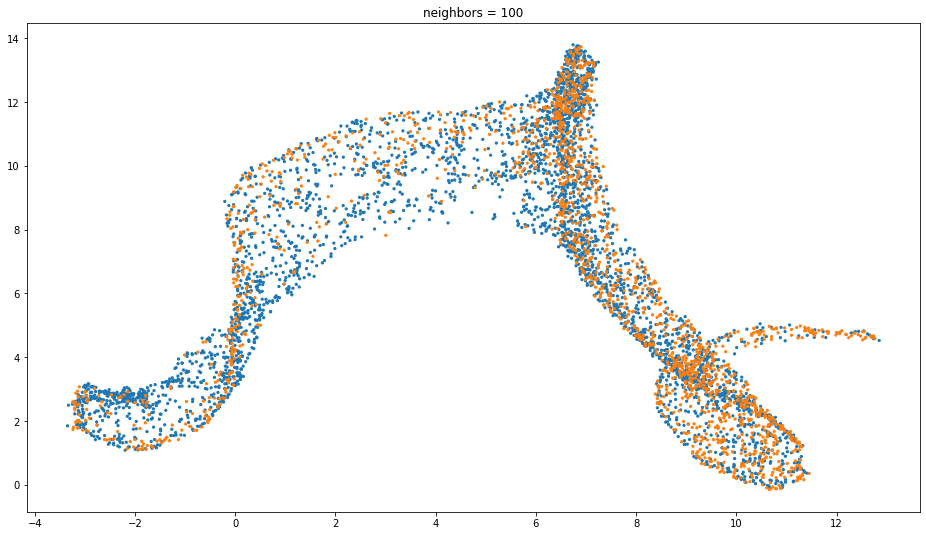

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for i, a in enumerate(b)],
    s=5)
ax.set_title('neighbors = {}'.format(reducer.n_neighbors))

Text(0.5, 0.92, 'neighbors = 100')

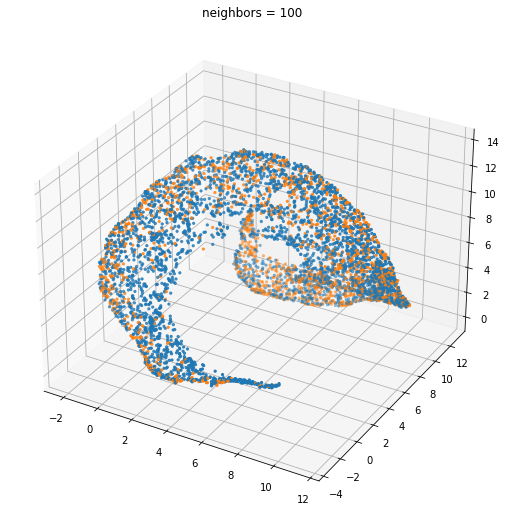

In [25]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embedding[:, 2],
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for i, a in enumerate(b)],
    s=5)
ax.set_title('neighbors = {}'.format(reducer.n_neighbors))

## Playground

In [131]:
class LoadImageRoseYoutu():
    def __init__(self, path_prefix, use_test = True, colorcvt=None):
        assert os.path.exists(path_prefix), "LoadImage, Path does not exist"
        self.path_prefix = path_prefix
        self.colorcvt = colorcvt

        self.to_use_folder = 'test' if use_test else 'adaptation'
        self.txt_file = self.to_use_folder + '_list.txt'
        self.img_path_prefix = os.path.join(self.path_prefix, 'rgb', self.to_use_folder)
        
        self.img_paths, self.folder_no, self.labels = self._read_txt_file()
        self.type = np.array([path.split('/')[1][0] for path in self.img_paths])

        self.next_idx = 0
        self.batch_size = 64

    def _read_txt_file(self):
        txt_path = os.path.join(self.path_prefix, self.txt_file)
        with open(txt_path, 'r') as f:
            text = f.readlines()
            lines = np.array([s.split() for s in text])
        return np.moveaxis(lines, -1, 0)
    
    def next_batch(self):
        images = []
        if self.next_idx >= len(self.labels):
            return None
        end_idx = min(len(self.labels), self.next_idx + self.batch_size)

        for i in range(self.next_idx, end_idx):
            file = os.path.join(self.img_path_prefix, self.img_paths[i] + '.jpg')
            img = cv2.imread(file)
            if img is not None:
                images.append(img)
        
        self.next_idx = end_idx
        return images


In [132]:
PATH_PREFIX = '/home/thienn17/Documents/Rose - Youtu/client'
loader = LoadImageRoseYoutu(PATH_PREFIX)

In [133]:
batch = loader.next_batch()

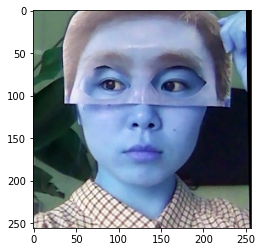

In [134]:
plt.imshow(batch[30])